# Imports and Configurations

In [86]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

np.set_printoptions(precision=3, suppress=True)
ecm = 'mean_absolute_error'
k_fold_value = 5

raw_dataset = pd.read_csv('dataset_v1.csv', sep=',', skipinitialspace=True)
dataset = raw_dataset.copy()
predict_set = dataset.tail(20)
dataset = dataset.drop(predict_set.index)

predictors = ['SampleNo', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']
all_test_results = {}

# Functions

In [87]:
# Utility Functions
def random_sampling(train_fraction=0.8):
    train = dataset.sample(frac=train_fraction, random_state=0)
    test = dataset.drop(train.index)
    return train, test


def k_fold_sampling(sample_source=dataset):
    kf = KFold(n_splits=k_fold_value, random_state=None, shuffle=False)

    features = np.array(sample_source[predictors])
    labels = np.array(sample_source['Y'])
    k_s = []
    for train_i, test_i in kf.split(dataset):
        k_s.append({'train_features': pd.DataFrame(features[train_i], columns=predictors),
                    'train_labels': labels[train_i],
                    'test_features': pd.DataFrame(features[test_i], columns=predictors),
                    'test_labels': labels[test_i]})
    return k_s


def k_fold_cv(samples, reg_func, arg=None):
    k_fold_cv_mae = 0
    k_fold_comparisons = []
    model_name = None
    for i in range(len(samples)):
        ki_result = reg_func(x_train=samples[i]['train_features'], y_train=samples[i]['train_labels'],
                             x_test=samples[i]['test_features'], y_test=samples[i]['test_labels'], arg=arg)
        model_name = ki_result['model']
        k_fold_comparisons.append(ki_result['comparison'])
        k_fold_cv_mae += ki_result['error']

    return {'model': model_name,
            'comparison': k_fold_comparisons,
            'error': k_fold_cv_mae / len(k_samples)}


def calculate_error(y_act, y_pred):
    def calculate_mae():
        test_error = 0
        for actual, predicted in zip(y_act, y_pred):
            test_error += abs(actual - predicted)
        return test_error / len(y_pred)

    def calculate_rmse():
        return np.sqrt(((y_act - y_pred) ** 2).sum() / len(y_pred))

    if ecm == 'mean_absolute_error':
        return calculate_mae()
    elif ecm == 'root_mean_squared_error':
        return calculate_rmse()
    else:
        print("You can't reach here.")


def display_error_dict(error_dict, transpose=True):
    error_table = pd.DataFrame([[k, v] for k, v in error_dict.items()], columns=['model', ecm])
    if transpose:
        error_table = error_table.transpose()
    display(error_table)


def sort_error_dict(result_dict):
    return dict(sorted(result_dict.items(), key=lambda item: item[1]))


# Regression Functions
def regression(model, x_train, y_train, x_test, y_test, results_as_df=True):
    x_regressor = LinearRegression().fit(x_train, y_train)
    y_predicted = x_regressor.predict(x_test)

    y_comparison = {'actual': list(y_test), 'predicted': y_predicted}
    mae_error = calculate_error(y_act=y_comparison['actual'], y_pred=y_comparison['predicted'])

    if results_as_df:
        y_comparison = pd.DataFrame(y_comparison).transpose()

    return {'model': model,
            'comparison': y_comparison,
            'error': mae_error}


def single_linear_regression(x_train, y_train, x_test, y_test, arg):
    return regression(model=f'linear_reg_{arg}',
                      x_train=np.array(x_train[arg])[:, None], y_train=y_train,
                      x_test=np.array(x_test[arg])[:, None], y_test=y_test)


def multiple_linear_regression(x_train, y_train, x_test, y_test, arg=predictors):
    return regression(model=f'mul_linear_reg_{arg}',
                      x_train=x_train[arg], y_train=y_train,
                      x_test=x_test[arg], y_test=y_test)


def polynomial_regression(x_train, y_train, x_test, y_test, arg=2):
    poly_features = PolynomialFeatures(degree=arg, include_bias=False)
    return regression(model=f'polynomial_reg_o={arg}',
                      x_train=poly_features.fit_transform(x_train), y_train=y_train,
                      x_test=poly_features.fit_transform(x_test), y_test=y_test)


def k_nearest_regression(x_train, y_train, x_test, y_test, arg=3):
    def euclidean_dist(p_x, p_y):
        distances = list(map(lambda pr: (p_x[pr] - p_y[pr]) ** 2, predictors))
        return sum(distances)

    predictions = []
    for i in range(len(x_test.index)):
        current_row = x_test.iloc[i]
        current_distances = [[y_train[n], euclidean_dist(current_row, x_train.iloc[n])]
                             for n in range(len(x_train.index))]
        current_distances.sort(key=lambda n: n[1])
        k_nearest_avg = sum([n[0] for n in current_distances[:arg]]) // arg
        predictions.append(k_nearest_avg)

    y_comparison = {'actual': list(y_test), 'predicted': predictions}
    reg_error = calculate_error(y_act=y_comparison['actual'], y_pred=y_comparison['predicted'])

    return {'model': f'k_nearest_reg_k={arg}',
            'comparison': pd.DataFrame(y_comparison).transpose(),
            'error': reg_error}

Before applying any machine learning algorithms, I wanted to see how each of the given predictors relate to each other.
To do it, I have found out pairplot() function from seaborn library which takes the name of columns (predictors) as
parameters and plots each one of them with another.

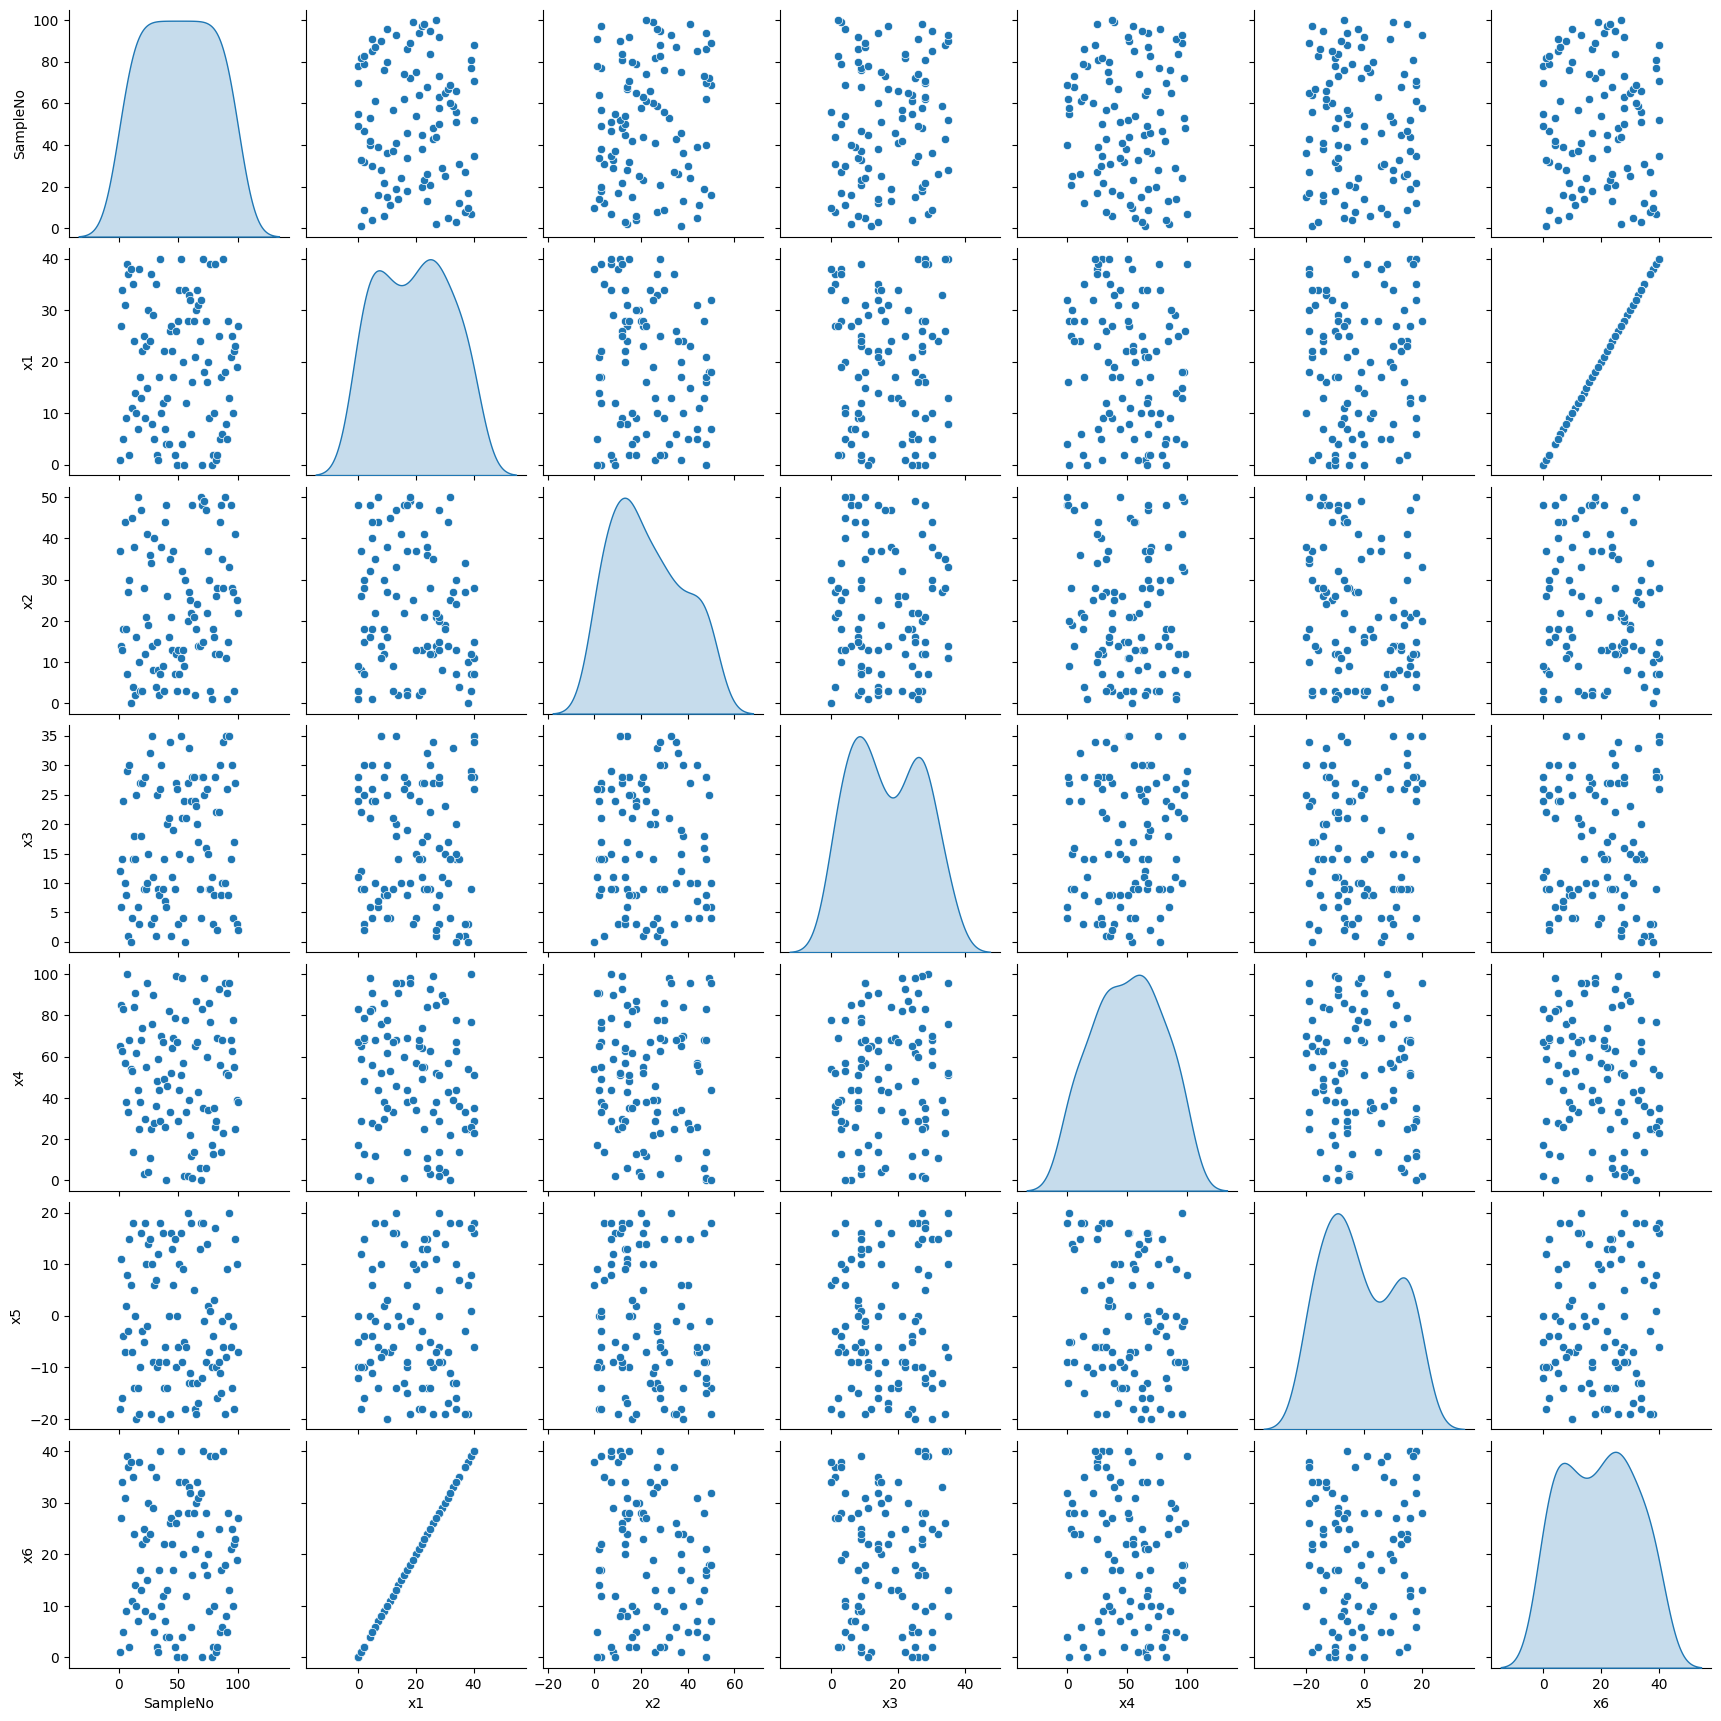

In [88]:
sns.pairplot(dataset[predictors], diag_kind='kde')

From looking at those results, it is clear that x1 and x6 values are exactly the same. So, I have decided to drop x6
predictor since we do not need the same values twice. Also, I have previously included SampleNo as a predictor (even it is
not really logical) just to see if it makes the algorithms perform better, which it obviously did not. So, I am also
dropping the SampleNo from the dataset and the predictors list.

In [89]:
dataset = dataset.drop('x6', axis=1)
predictors.remove('x6')

dataset = dataset.drop('SampleNo', axis=1)
predictors.remove('SampleNo')

Now, I wanted to see how each of those predictors relate to Y separately.

,min,max,mean,std
x1,0.0,40.0,19.29,12.315954
x2,0.0,50.0,22.53,15.019486
x3,0.0,35.0,16.68,10.375651
x4,0.0,100.0,50.60,28.242814
x5,-20.0,20.0,-1.44,12.270783
Y,-42.0,12402.0,1746.82,2696.083648


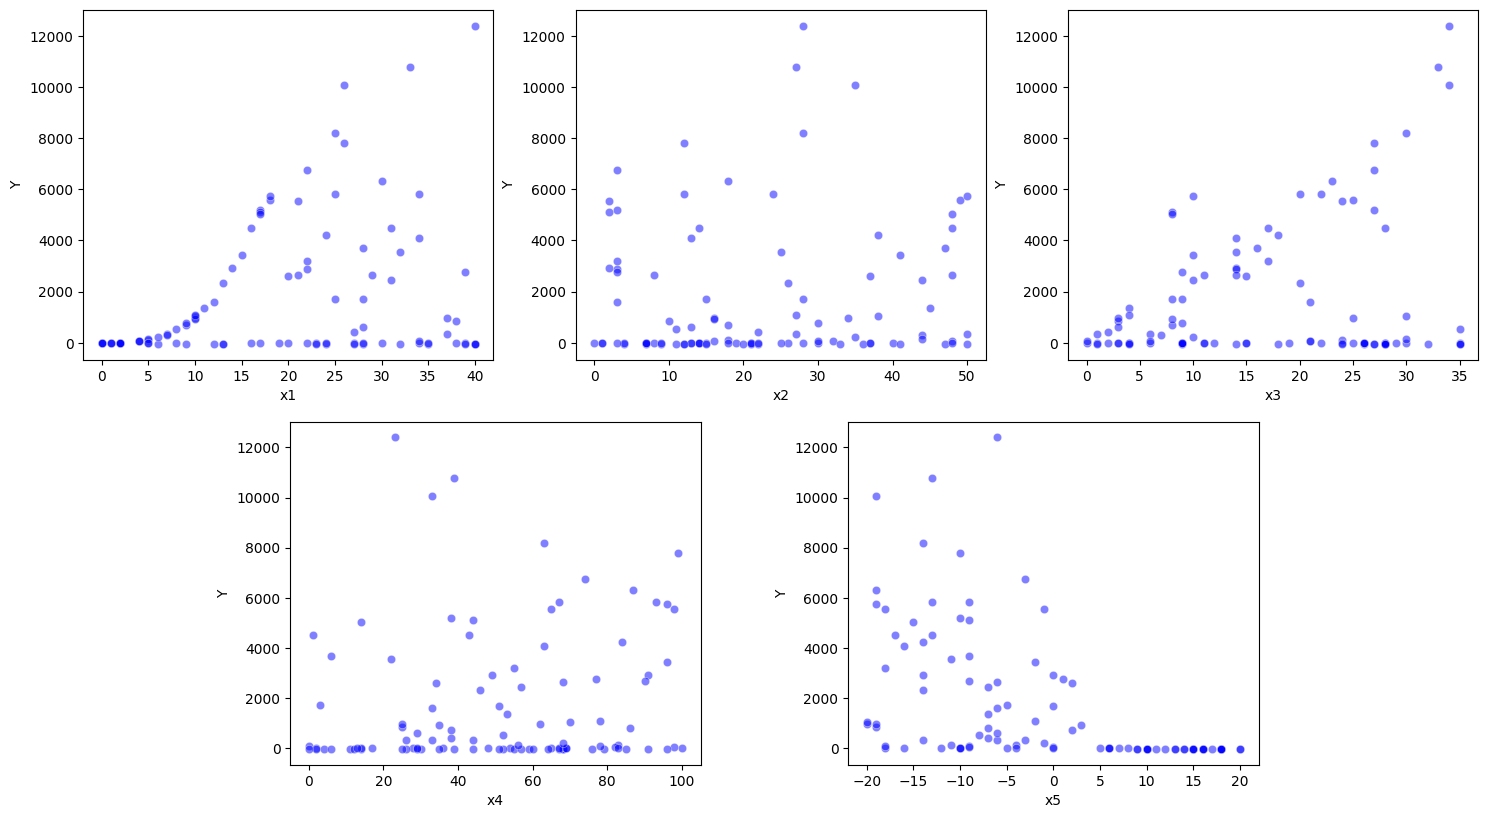

In [90]:
fig_, axes_ = plt.subplots(2, 3, figsize=(18, 10))
axes_[1][2].set_visible(False)
axes_[1][0].set_position([0.24, 0.125, 0.228, 0.343])
axes_[1][1].set_position([0.55, 0.125, 0.228, 0.343])

for i_ in range(len(predictors)):
    sns.scatterplot(ax=axes_[i_ // 3, i_ % 3], x=dataset[predictors[i_]], y=dataset['Y'], alpha=0.5, color='b')

table_heuristics = dataset.describe().transpose()[['min', 'max', 'mean', 'std']]
display(table_heuristics)

From here, I can see that when x1 has low values, their corresponding Y values are also tend to be lower. Similarly,
when x5 has a value greater than 5, its corresponding Y value is lower. Because of this, I assume that some kind of
classification method must be applied.

In [91]:
from sklearn.preprocessing import StandardScaler, normalize

scaled_data = StandardScaler().fit_transform(dataset[predictors])
x_normalized = normalize(scaled_data, norm='l1', axis=1)
dataset_normalized = pd.DataFrame(x_normalized, columns=predictors)

dataset_normalized['Y'] = dataset['Y']
dataset = dataset_normalized
k_samples = k_fold_sampling(dataset)

,min,max,mean,std
x1,-0.402323,0.380985,-0.002308,0.224379
x2,-0.454834,0.550469,-0.007396,0.235051
x3,-0.475517,0.437675,-0.012894,0.232820
x4,-0.475625,0.414835,0.005999,0.223216
x5,-0.455289,0.450707,-0.006444,0.232867
Y,-42.000000,12402.000000,1746.820000,2696.083648


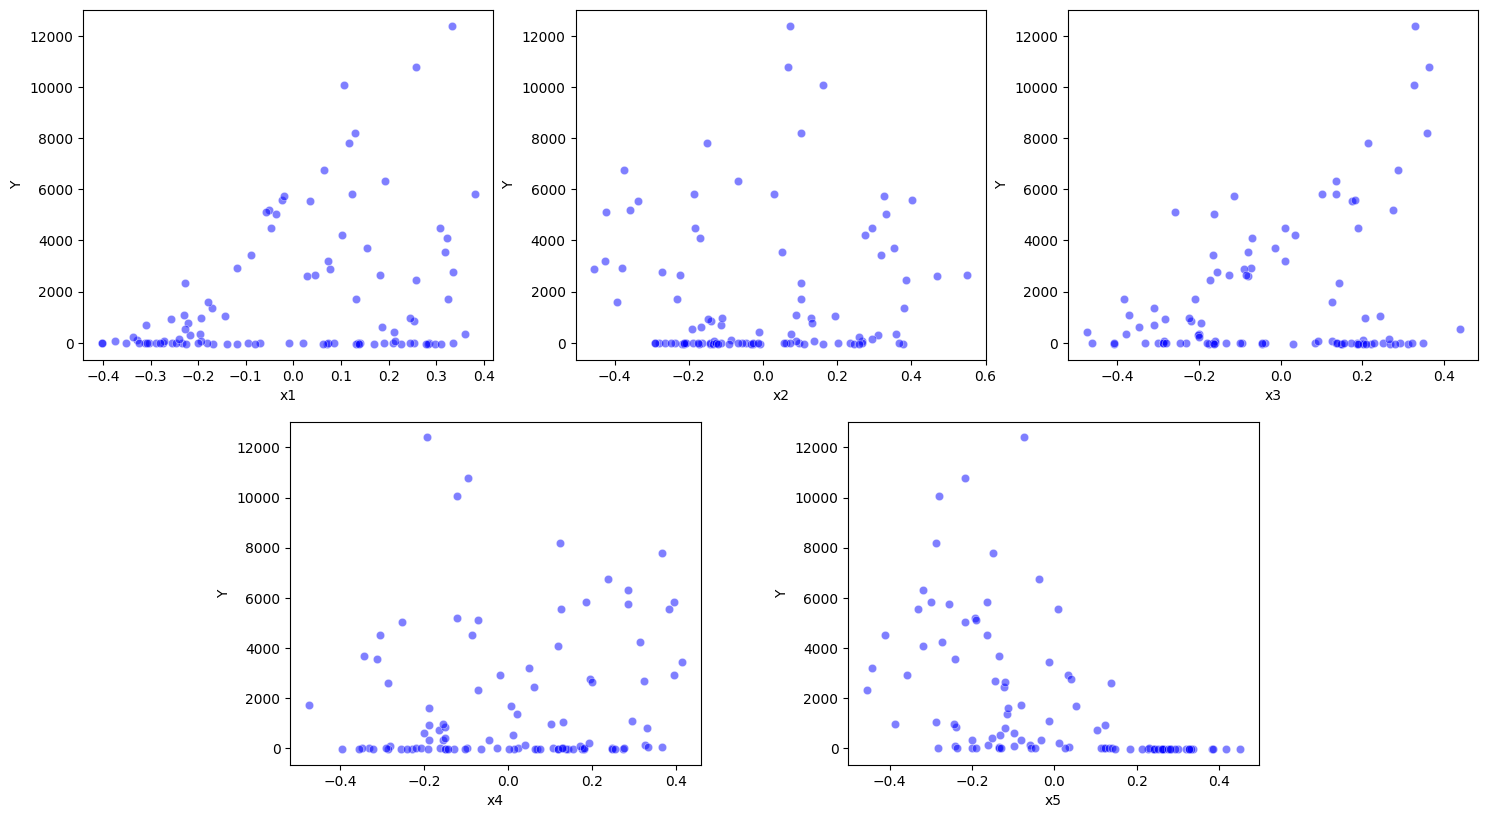

In [92]:
fig_, axes_ = plt.subplots(2, 3, figsize=(18, 10))
axes_[1][2].set_visible(False)
axes_[1][0].set_position([0.24, 0.125, 0.228, 0.343])
axes_[1][1].set_position([0.55, 0.125, 0.228, 0.343])

for i_ in range(len(predictors)):
    sns.scatterplot(ax=axes_[i_ // 3, i_ % 3], x=dataset[predictors[i_]], y=dataset['Y'], alpha=0.5, color='b')

table_heuristics = dataset.describe().transpose()[['min', 'max', 'mean', 'std']]
display(table_heuristics)

# I. Linear Regression

## I.I. Single Linear Regression

,0,1,2,3,4
model,linear_reg_x5,linear_reg_x1,linear_reg_x3,linear_reg_x4,linear_reg_x2
mean_absolute_error,1597.00334,1902.45699,2057.478625,2086.193614,2130.104382


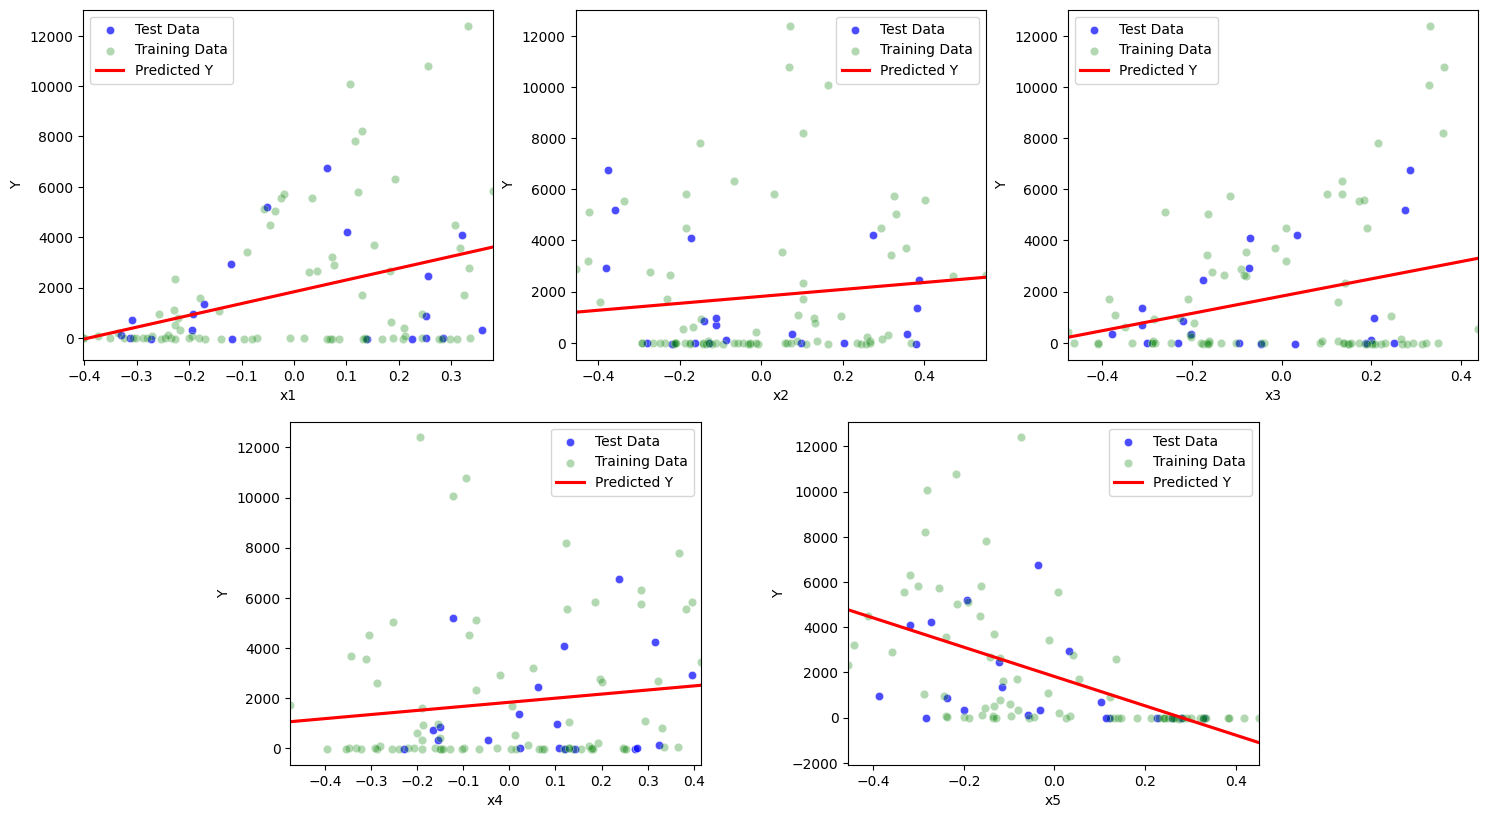

In [93]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes[1][2].set_visible(False)
axes[1][0].set_position([0.24, 0.125, 0.228, 0.343])
axes[1][1].set_position([0.55, 0.125, 0.228, 0.343])

lin_error_dict = {}
ax_i = 0
for p in predictors:
    ax = axes[ax_i // 3, ax_i % 3]

    k_fold_result = k_fold_cv(k_samples, single_linear_regression, arg=p)
    lin_error_dict[k_fold_result['model']] = k_fold_result['error']

    sns.scatterplot(ax=ax, x=k_samples[0]['test_features'][p], y=k_samples[0]['test_labels'],
                    alpha=0.7, color='b', label='Test Data')
    sns.scatterplot(ax=ax, x=k_samples[0]['train_features'][p], y=k_samples[0]['train_labels'],
                    alpha=0.3, color='g', label='Training Data')
    sns.regplot(ax=ax, x=k_samples[0]['test_features'][p], y=k_fold_result['comparison'][0].loc['predicted'],
                color='r', scatter=False, label='Predicted Y', truncate=False)

    ax.set_xlim(table_heuristics['min'][p], table_heuristics['max'][p])
    ax.set_xlabel(p)
    ax.set_ylabel('Y')
    ax.legend()
    ax_i += 1

lin_error_dict = sort_error_dict(lin_error_dict)
display_error_dict(lin_error_dict)

best_performing_model = list(lin_error_dict.items())[0]
all_test_results[best_performing_model[0]] = best_performing_model[1]
all_test_results = sort_error_dict(all_test_results)

## I.II. Multiple Linear Regression

In [94]:
import itertools

predictor_combinations = []
for L in range(2, len(predictors)+1):
    predictor_combinations.extend(itertools.combinations(predictors, L))

multi_lin_reg_args = list(map(list, predictor_combinations))
multi_lin_reg_results = [k_fold_cv(samples=k_samples, reg_func=multiple_linear_regression, arg=ps)
                         for ps in multi_lin_reg_args]

multi_lin_error_dict = {}
for multi_lin_reg_result in multi_lin_reg_results:
    multi_lin_error_dict[multi_lin_reg_result['model']] = multi_lin_reg_result['error']
multi_lin_error_dict = sort_error_dict(multi_lin_error_dict)
display_error_dict(multi_lin_error_dict)

best_performing_model = list(multi_lin_error_dict.items())[0]
all_test_results[best_performing_model[0]] = best_performing_model[1]
all_test_results = sort_error_dict(all_test_results)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
model,"mul_linear_reg_['x1', 'x4', 'x5']","mul_linear_reg_['x1', 'x3', 'x4', 'x5']","mul_linear_reg_['x1', 'x2', 'x4', 'x5']","mul_linear_reg_['x1', 'x2', 'x3', 'x4', 'x5']","mul_linear_reg_['x1', 'x5']","mul_linear_reg_['x1', 'x3', 'x5']","mul_linear_reg_['x1', 'x2', 'x3', 'x5']","mul_linear_reg_['x1', 'x2', 'x5']","mul_linear_reg_['x4', 'x5']","mul_linear_reg_['x2', 'x5']",...,"mul_linear_reg_['x1', 'x4']","mul_linear_reg_['x1', 'x3', 'x4']","mul_linear_reg_['x1', 'x3']","mul_linear_reg_['x1', 'x2', 'x3']","mul_linear_reg_['x1', 'x2', 'x4']","mul_linear_reg_['x1', 'x2']","mul_linear_reg_['x3', 'x4']","mul_linear_reg_['x2', 'x3', 'x4']","mul_linear_reg_['x2', 'x3']","mul_linear_reg_['x2', 'x4']"
mean_absolute_error,1538.592597,1549.988448,1557.227843,1557.582121,1562.241355,1580.062594,1584.151518,1587.037258,1606.581323,1620.612017,...,1882.205067,1886.361616,1893.286757,1899.656591,1910.644072,1930.96414,2049.434767,2058.012528,2066.341223,2104.00789


## I.III. Polynomial Regression

In [95]:
poly_reg_args = [2, 3, 4]
poly_reg_results = [k_fold_cv(samples=k_samples, reg_func=polynomial_regression, arg=order) for order in poly_reg_args]

poly_error_dict = {}
for poly_reg_result in poly_reg_results:
    poly_error_dict[poly_reg_result['model']] = poly_reg_result['error']
poly_error_dict = sort_error_dict(poly_error_dict)
display_error_dict(poly_error_dict)

best_performing_model = list(poly_error_dict.items())[0]
all_test_results[best_performing_model[0]] = best_performing_model[1]
all_test_results = sort_error_dict(all_test_results)

,0,1,2
model,polynomial_reg_o=2,polynomial_reg_o=3,polynomial_reg_o=4
mean_absolute_error,1125.913427,1733.312268,2156.382084


## I.IV. K-Nearest-Neighbors Regression

In [96]:
knn_args = [2, 3, 4, 5]

k_nearest_results = [k_fold_cv(samples=k_samples, reg_func=k_nearest_regression, arg=k) for k in knn_args]

knn_error_dict = {}
for knn_result in k_nearest_results:
    knn_error_dict[knn_result['model']] = knn_result['error']
knn_error_dict = sort_error_dict(knn_error_dict)
display_error_dict(knn_error_dict)

best_performing_model = list(knn_error_dict.items())[0]
all_test_results[best_performing_model[0]] = best_performing_model[1]
all_test_results = sort_error_dict(all_test_results)


,0,1,2,3
model,k_nearest_reg_k=3,k_nearest_reg_k=2,k_nearest_reg_k=5,k_nearest_reg_k=4
mean_absolute_error,879.9,891.84,1062.53,1079.25


In [97]:
display_error_dict(all_test_results, transpose=False)

,model,mean_absolute_error
0,k_nearest_reg_k=3,879.900000
1,polynomial_reg_o=2,1125.913427
2,"mul_linear_reg_['x1', 'x4', 'x5']",1538.592597
3,linear_reg_x5,1597.003340


In [98]:
%reload_ext watermark
%watermark -v -m -p sklearn,pandas,numpy,matplotlib,seaborn
%watermark -u -n -t -z

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

sklearn   : 1.1.1
pandas    : 1.4.2
numpy     : 1.22.4
matplotlib: 3.5.2
seaborn   : 0.11.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 167 Stepping 1, GenuineIntel
CPU cores   : 12
Architecture: 64bit

Last updated: Sat May 28 2022 22:24:48Turkey Standard Time



# TESTING

In [112]:
X, y = raw_dataset.head(100)[['x1', 'x2', 'x3', 'x4', 'x5']], dataset['Y']

feature_names = np.array(['x1', 'x2', 'x3', 'x4', 'x5'])

def ridge_based_selection():
    from sklearn.feature_selection import SequentialFeatureSelector
    from sklearn.feature_selection import SelectFromModel
    from sklearn.linear_model import RidgeCV

    ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X, y)
    importance = np.abs(ridge.coef_)

    plt.bar(height=importance, x=feature_names)
    plt.title("Feature importances via coefficients")
    plt.show()

    sfm = SelectFromModel(ridge).fit(X, y)
    print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")

    sfs_forward = SequentialFeatureSelector(ridge, n_features_to_select=3, direction="forward").fit(X, y)


    sfs_backward = SequentialFeatureSelector(ridge, n_features_to_select=3, direction="backward").fit(X, y)


    print("Features selected by forward sequential selection: "
        f"{feature_names[sfs_forward.get_support()]}"
    )

    print("Features selected by backward sequential selection: "
        f"{feature_names[sfs_backward.get_support()]}")

def random_forest_pipeline():
    from sklearn.ensemble import ExtraTreesClassifier
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.feature_selection import SelectFromModel
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=80, test_size=20, random_state=1)

    clf = Pipeline([
        ('feature_selection', SelectFromModel(ExtraTreesClassifier(n_estimators=50))),
        ('regression', RandomForestRegressor(max_depth=2, random_state=0))
    ]).fit(X_train, y_train)

    predictions = clf.predict(X_test)
    display(calculate_error(y_test, predictions))

random_forest_pipeline()

984.6595548503899